<a href="https://colab.research.google.com/github/amirgros/46211-Deep-Learning-Project/blob/main/CNN%20based/Image_Colorization_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Based Image Colorizer - UNET Architecture

This implementation is based on the UNET architecture, with 4 up/down layers. There are 3 configurations for the model with different layer composition, details below. \
Loss is MSE. Dataset is "landscape Images" from Kaggle (brought as zip).\


In [ ]:
!unzip -q "Recolorization Images.zip" -d './'

In [ ]:
# Imports
import os
import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from torchvision.models import vgg16
import torch.nn.functional as F
import numpy as np


In [ ]:
MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

In [ ]:
# Create dataset to load the images
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = './landscape Images'
        self.images   = os.listdir(f'{self.dataroot}/color')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]

        color_img = read_image(f'{self.dataroot}/color/{img_path}') / 255
        gray_img  = read_image(f'{self.dataroot}/gray/{img_path}')  / 255

        if self.transform:
            color_img = self.transform(color_img)
            gray_img  = self.transform(gray_img)
            return color_img, gray_img


**In option 3, sizes were changed from 150, 150 to 224, 224**

In [ ]:
transform = transforms.Compose([transforms.Resize((224, 224), antialias=False)])
###In option 3, sizes were changed from 150, 150 to 224, 224###


dataset = LandscapeDataset(transform=transform)

# Split the data into train and test data
train_set, test_set = random_split(
    dataset, [0.8, 0.2],
    generator=torch.Generator().manual_seed(MANUAL_SEED)
)

# Load the train and test data
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=SHUFFLE)


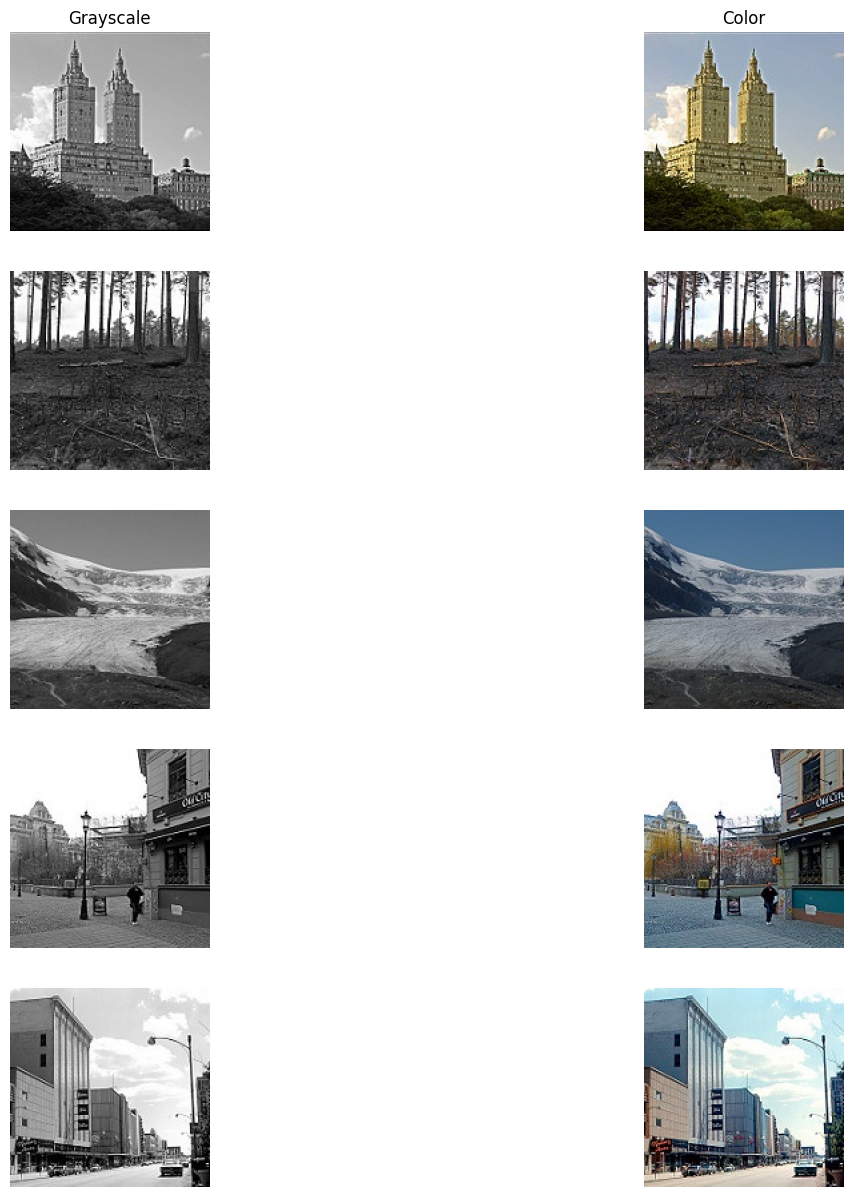

In [ ]:
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1, 2, 0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1, 2, 0))
        axs[i, 1].axis('off')
    plt.show()

color, gray = next(iter(trainloader))
show_images(color, gray)


In [ ]:
# Training Variables
EPOCHS         = 100
LEARNING_RATE  = 0.001
MOMENTUM       = 0.9
DEVICE         = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Create the autoencoder model
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.down1 = nn.Conv2d(1,   64, 3, stride=2)
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1)

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256,  64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128,   3, 3, stride=2,               output_padding=1)

        self.relu    = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down-sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))

        # Upsample
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1, d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3, d1), dim=1)))

        return u4


**option 2 of the class:**

In [ ]:
'''
Up-levelled colour-autoencoder
  • BatchNorm + LeakyReLU after every conv
  • Dilated layer for larger receptive-field context
  • Transposed-conv blocks wrapped in BN/activation to tame artefacts
  • Changed activation function from sigmoid to tanh, keeping output in [-1, 1]
'''
import torch.nn as nn
import torch

class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # ── helpers ────────────────────────────────────────────────────────────
        def down_block(in_c, out_c, pad):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, stride=2, padding=pad, bias=False),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )

        def up_block(in_c, out_c, pad, out_pad=0):
            return nn.Sequential(
                nn.ConvTranspose2d(
                    in_c, out_c, 3, stride=2,
                    padding=pad, output_padding=out_pad, bias=False
                ),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2, inplace=True)
            )

        # encoder
        self.down1 = down_block(1,   64, pad=0)
        self.down2 = down_block(64, 128, pad=1)
        self.down3 = down_block(128, 256, pad=1)
        self.down4 = down_block(256, 512, pad=1)

        self.bridge = nn.Sequential(
            nn.Conv2d(512, 512, 3, dilation=2, padding=2, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # decoder
        self.up1 = up_block(512, 256, pad=1)
        self.up2 = up_block(512, 128, pad=1)
        self.up3 = up_block(256,  64, pad=1, out_pad=1)
        self.up4 = nn.Sequential(nn.ConvTranspose2d(
        128, 3,
        kernel_size=5,
        stride=2,
        padding=1,
        output_padding=1,
        bias=False
    ),
    nn.Tanh()
)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')

    # forward
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        b  = self.bridge(d4)

        u1 = self.up1(b)
        u2 = self.up2(torch.cat([u1, d3], dim=1))
        u3 = self.up3(torch.cat([u2, d2], dim=1))
        out = self.up4(torch.cat([u3, d1], dim=1))

        return out


***Option 3: 224x224 no batch norm, returning to relu and sigmoid***

In [ ]:
# Colour-autoencoder for 224×224 inputs
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.down1 = nn.Conv2d(1,   64, 3, stride=2, padding=1)
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1)

        # Decoder
        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2,
                                      padding=1, output_padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2,
                                      padding=1, output_padding=1)
        self.up3 = nn.ConvTranspose2d(256,  64, 3, stride=2,
                                      padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128,   3, 3, stride=2,
                                      padding=1, output_padding=1)

        self.relu    = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down-sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))

        # Up-sample with skip connections
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat([u1, d3], dim=1)))
        u3 = self.relu(self.up3(torch.cat([u2, d2], dim=1)))
        out = self.sigmoid(self.up4(torch.cat([u3, d1], dim=1)))

        return out


In [ ]:
# Initialize the model
model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total Number of trainable parameters of this model are: {total_params:,}"

'Total Number of trainable parameters of this model are: 3,470,659'


**added a scheduler for the 100 epoch training run**

In [ ]:
# Initialize the optimizer and loss function
criterion  = nn.MSELoss()
optimizer  = optim.Adam(model.parameters(), lr=LEARNING_RATE)


scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.35, patience=3, verbose=True
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Training loop
for epoch in range(EPOCHS):
    running_loss = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(DEVICE)
        gray_img  = gray_img.to(DEVICE)

        predictions = model(gray_img)

        optimizer.zero_grad()

        loss = criterion(color_img, predictions)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch: {epoch + 1}, Loss: {running_loss:.6f}')

  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 1, Loss: 2.416110


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 2, Loss: 1.368777


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 3, Loss: 1.199450


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 4, Loss: 1.113749


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 5, Loss: 1.079420


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 6, Loss: 1.045126


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 7, Loss: 1.025211


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 8, Loss: 1.011920


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.991126


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.993404


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.969999


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.961215


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.961458


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.956243


  0%|          | 0/179 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.938302


New training with **checkpoints**

In [ ]:
best_val_loss   = np.inf
patience        = 15          # epochs to wait before stopping
epochs_no_improve = 0
save_path       = 'best_colorAE.pth'


In [ ]:
for epoch in range(EPOCHS):
    # TRAIN
    model.train()
    train_loss = 0.0
    for color_img, gray_img in trainloader:
        color_img, gray_img = color_img.to(DEVICE), gray_img.to(DEVICE)

        pred = model(gray_img)
        loss = criterion(color_img, pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * color_img.size(0)

    train_loss /= len(trainloader.dataset)

    # VALIDATE
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for color_img, gray_img in testloader:
            color_img, gray_img = color_img.to(DEVICE), gray_img.to(DEVICE)

            pred = model(gray_img)
            loss = criterion(color_img, pred)
            val_loss += loss.item() * color_img.size(0)

    val_loss /= len(testloader.dataset)

    # Scheduler & Early-stop logic
    scheduler.step(val_loss)

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), save_path)
        improved = " ✅ best so far"
    else:
        epochs_no_improve += 1
        improved = ""

    print(f"Epoch {epoch+1:03d} | train {train_loss:.4f} | val {val_loss:.4f}{improved}")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

print(f"Best validation loss: {best_val_loss:.7f} (model saved to {save_path})")


Epoch 001 | train 0.0099 | val 0.0083 ✅ best so far
Epoch 002 | train 0.0072 | val 0.0076 ✅ best so far
Epoch 003 | train 0.0067 | val 0.0065 ✅ best so far
Epoch 004 | train 0.0062 | val 0.0061 ✅ best so far
Epoch 005 | train 0.0060 | val 0.0061
Epoch 006 | train 0.0059 | val 0.0059 ✅ best so far
Epoch 007 | train 0.0056 | val 0.0068
Epoch 008 | train 0.0057 | val 0.0058 ✅ best so far
Epoch 009 | train 0.0056 | val 0.0057
Epoch 010 | train 0.0055 | val 0.0058
Epoch 011 | train 0.0055 | val 0.0076
Epoch 012 | train 0.0056 | val 0.0054 ✅ best so far
Epoch 013 | train 0.0054 | val 0.0059
Epoch 014 | train 0.0053 | val 0.0056
Epoch 015 | train 0.0053 | val 0.0054
Epoch 016 | train 0.0052 | val 0.0054
Epoch 017 | train 0.0052 | val 0.0054
Epoch 018 | train 0.0053 | val 0.0053
Epoch 019 | train 0.0052 | val 0.0053 ✅ best so far
Epoch 020 | train 0.0051 | val 0.0056
Epoch 021 | train 0.0051 | val 0.0053
Epoch 022 | train 0.0051 | val 0.0053
Epoch 023 | train 0.0050 | val 0.0054
Epoch 024 | tr

In [ ]:
# Test on testing data
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img  = gray_img.to(DEVICE)

        prediction = model(gray_img)

        loss = criterion(prediction, color_img)
        total_loss += loss.item()

print(f"Total Testing loss is: {(total_loss / len(testloader)):.10f}")


  0%|          | 0/45 [00:00<?, ?it/s]

Total Testing loss is: 0.0050373509


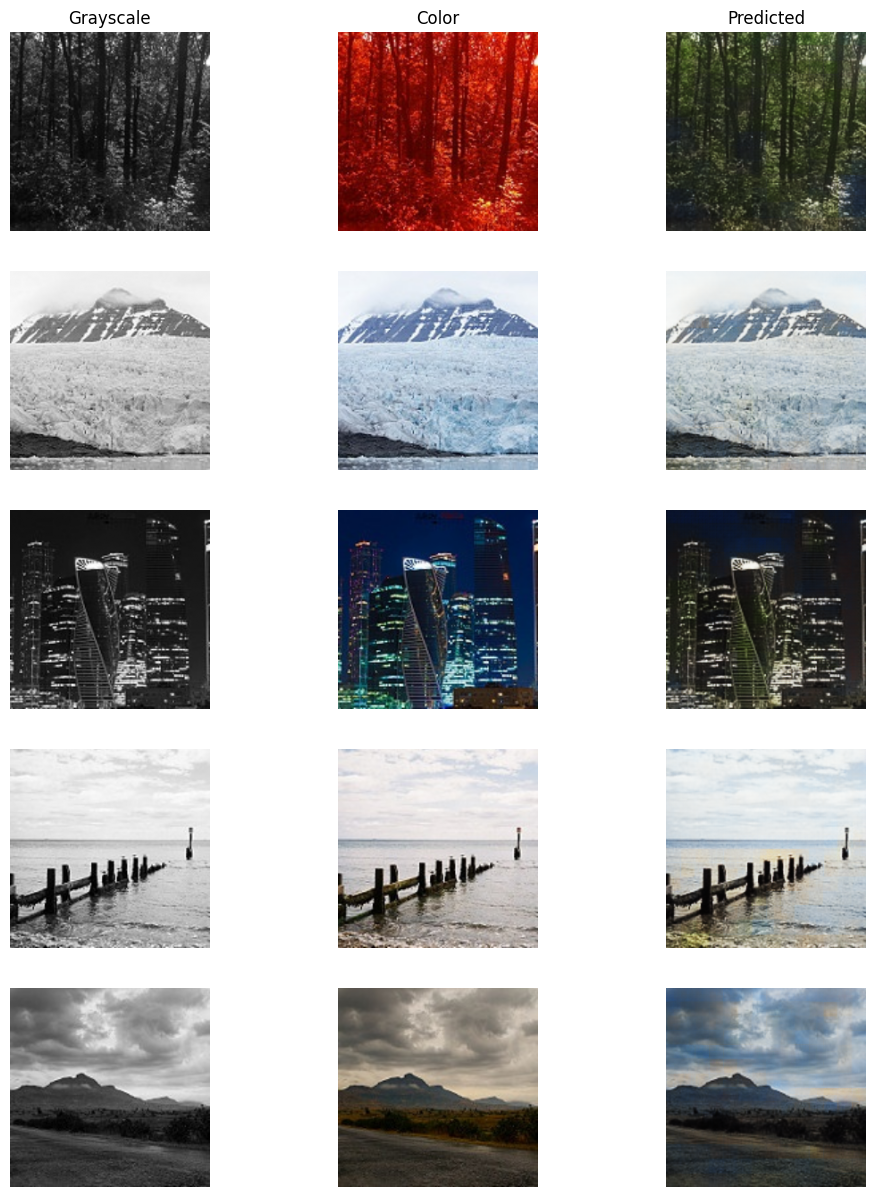

In [ ]:
# Visualize predictions
def show_predictions(color, gray, pred):
    fig, axs = plt.subplots(5, 3, figsize=(12, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1, 2, 0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1, 2, 0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1, 2, 0))
    plt.show()

show_predictions(
    color_img.detach().cpu(),
    gray_img.detach().cpu(),
    prediction.detach().cpu()
)


**Visualizing of the best model after training 100 times**

Testing:   0%|          | 0/45 [00:00<?, ?it/s]

Average test loss per pixel: 0.005092


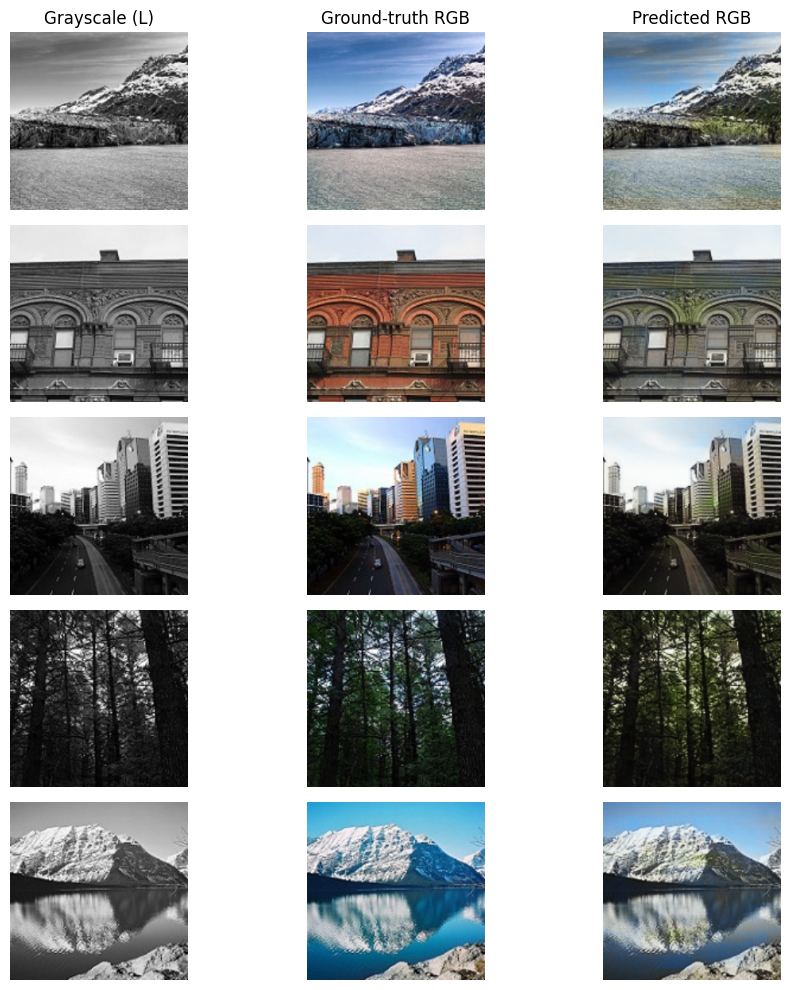

In [ ]:

#Loading the best model weights

best_path = 'best_colorAE.pth'
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
model.eval()

# Evaluating on the entire test set
total_loss = 0.0
num_pixels = 0

with torch.no_grad():
    for color_img, gray_img in tqdm(testloader, desc="Testing"):
        color_img, gray_img = color_img.to(DEVICE), gray_img.to(DEVICE)

        pred = model(gray_img)
        loss = criterion(pred, color_img)

        total_loss += loss.item() * color_img.numel()
        num_pixels += color_img.numel()

avg_loss = total_loss / num_pixels
print(f"Average test loss per pixel: {avg_loss:.6f}")


# Visualise sample predictions
def show_predictions(gt, gray, pred, n=5):
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(n, 3, figsize=(10, 2*n))
    titles = ['Grayscale (L)', 'Ground-truth RGB', 'Predicted RGB']
    for j, t in enumerate(titles): axs[0, j].set_title(t)

    for i in range(n):
        axs[i, 0].imshow(gray[i].permute(1,2,0).cpu(), cmap='gray'); axs[i,0].axis('off')
        axs[i, 1].imshow(gt[i].permute(1,2,0).cpu());                axs[i,1].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0).clamp(0,1).cpu());   axs[i,2].axis('off')

    plt.tight_layout(); plt.show()

color_gt, gray_in = next(iter(testloader))
with torch.no_grad():
    preds = model(gray_in.to(DEVICE)).cpu()

show_predictions(color_gt, gray_in, preds)
